In [1]:
import tensorflow as tf
import os
import json
import pandas as pd
import re
import numpy as np
import time
import matplotlib.pyplot as plt
import collections
import random
import requests
import json
from math import sqrt
from PIL import Image
from tqdm.auto import tqdm

c:\Users\IDAC PC\AppData\Local\Programs\Python\Python39\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [9]:
BASE_PATH = "C:/Users/IDAC PC/Desktop/UtkuThesis/ImageCaptioning1/datasets/coco2017"

In [10]:
with open(f'{BASE_PATH}/annotations/captions_train2017.json', 'r') as f:
    data = json.load(f)
    data = data['annotations']

img_cap_pairs = []

for sample in data:
    img_name = '%012d.jpg' % sample['image_id']
    img_cap_pairs.append([img_name, sample['caption']])

captions = pd.DataFrame(img_cap_pairs, columns=['image', 'caption'])
captions['image'] = captions['image'].apply(
    lambda x: f'{BASE_PATH}/train2017/{x}'
)
#print(captions.shape)
captions = captions.sample(70000)
captions = captions.reset_index(drop=True)
captions.head()

,image,caption
0,C:/Users/IDAC PC/Desktop/UtkuThesis/ImageCapti...,A black and white photo of two men and a horse.
1,C:/Users/IDAC PC/Desktop/UtkuThesis/ImageCapti...,A girl interacting with four horses in a field
2,C:/Users/IDAC PC/Desktop/UtkuThesis/ImageCapti...,A large stone building with statues on top
3,C:/Users/IDAC PC/Desktop/UtkuThesis/ImageCapti...,A train that is yellow is moving down the tracks.
4,C:/Users/IDAC PC/Desktop/UtkuThesis/ImageCapti...,A tall clock tower stands next to a cathedral.


In [11]:
def preprocess(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub('\s+', ' ', text)
    text = text.strip()
    text = '[start] ' + text + ' [end]'
    return text

In [12]:
captions['caption'] = captions['caption'].apply(preprocess)
captions.head()

,image,caption
0,C:/Users/IDAC PC/Desktop/UtkuThesis/ImageCapti...,[start] a black and white photo of two men and...
1,C:/Users/IDAC PC/Desktop/UtkuThesis/ImageCapti...,[start] a girl interacting with four horses in...
2,C:/Users/IDAC PC/Desktop/UtkuThesis/ImageCapti...,[start] a large stone building with statues on...
3,C:/Users/IDAC PC/Desktop/UtkuThesis/ImageCapti...,[start] a train that is yellow is moving down ...
4,C:/Users/IDAC PC/Desktop/UtkuThesis/ImageCapti...,[start] a tall clock tower stands next to a ca...


[start] a man coming to rest after falling from a snowboard [end]



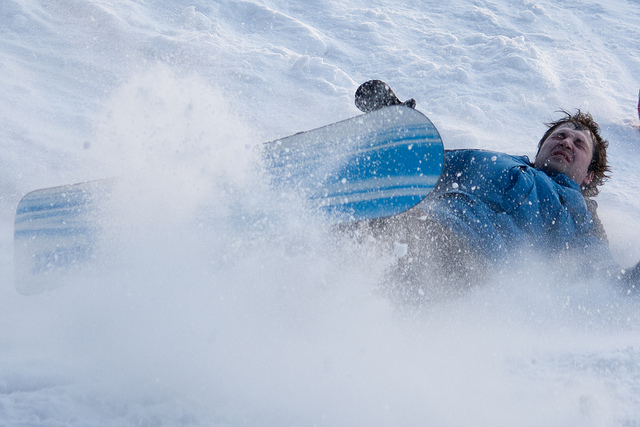

In [13]:
random_row = captions.sample(1).iloc[0]
print(random_row.caption)
print()
im = Image.open(random_row.image)
im

In [14]:
MAX_LENGTH = 40
VOCABULARY_SIZE = 150000
BATCH_SIZE = 64
BUFFER_SIZE = 1000
EMBEDDING_DIM = 512
UNITS = 512
EPOCHS = 5

In [15]:
tokenizer = tf.keras.layers.TextVectorization(
    max_tokens=VOCABULARY_SIZE,
    standardize=None,
    output_sequence_length=MAX_LENGTH)

tokenizer.adapt(captions['caption'])

In [16]:
tokenizer.vocabulary_size()

11987

In [20]:
len(tokenizer.get_vocabulary())

11987

In [23]:
import pickle

pickle.dump(tokenizer.get_vocabulary(), open('vocab_coco.file', 'wb'))

In [24]:
word2idx = tf.keras.layers.StringLookup(
    mask_token="",
    vocabulary=tokenizer.get_vocabulary())

idx2word = tf.keras.layers.StringLookup(
    mask_token="",
    vocabulary=tokenizer.get_vocabulary(),
    invert=True)

In [25]:
img_to_cap_vector = collections.defaultdict(list)
for img, cap in zip(captions['image'], captions['caption']):
    img_to_cap_vector[img].append(cap)

img_keys = list(img_to_cap_vector.keys())
random.shuffle(img_keys)

slice_index = int(len(img_keys)*0.8)
img_name_train_keys, img_name_val_keys = (img_keys[:slice_index], 
                                          img_keys[slice_index:])

train_imgs = []
train_captions = []
for imgt in img_name_train_keys:
    capt_len = len(img_to_cap_vector[imgt])
    train_imgs.extend([imgt] * capt_len)
    train_captions.extend(img_to_cap_vector[imgt])

val_imgs = []
val_captions = []
for imgv in img_name_val_keys:
    capv_len = len(img_to_cap_vector[imgv])
    val_imgs.extend([imgv] * capv_len)
    val_captions.extend(img_to_cap_vector[imgv])

In [26]:
len(train_imgs), len(train_captions), len(val_imgs), len(val_captions)

(55894, 55894, 14106, 14106)

In [27]:
def load_data(img_path, caption):
    img = tf.io.read_file(img_path)
    img = tf.io.decode_jpeg(img, channels=3)
    img = tf.keras.layers.Resizing(299, 299)(img)
    img = tf.keras.applications.resnet50.preprocess_input(img)
    caption = tokenizer(caption)
    return img, caption

In [28]:
train_dataset = tf.data.Dataset.from_tensor_slices(
    (train_imgs, train_captions))

train_dataset = train_dataset.map(
    load_data, num_parallel_calls=tf.data.AUTOTUNE
    ).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

val_dataset = tf.data.Dataset.from_tensor_slices(
    (val_imgs, val_captions))

val_dataset = val_dataset.map(
    load_data, num_parallel_calls=tf.data.AUTOTUNE
    ).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [29]:
image_augmentation = tf.keras.Sequential(
    [
        tf.keras.layers.RandomFlip("horizontal"),
        tf.keras.layers.RandomRotation(0.2),
        tf.keras.layers.RandomContrast(0.3),
    ]
)

In [30]:
def CNN_Encoder():
    resnet50 = tf.keras.applications.ResNet50(
        include_top=False,
        weights='imagenet'
    )

    output = resnet50.output
    output = tf.keras.layers.Reshape(
        (-1, output.shape[-1]))(output)

    cnn_model = tf.keras.models.Model(resnet50.input, output)
    return cnn_model

In [31]:
class TransformerEncoderLayer(tf.keras.layers.Layer):

    def __init__(self, embed_dim, num_heads):
        super().__init__()
        self.layer_norm_1 = tf.keras.layers.LayerNormalization()
        self.layer_norm_2 = tf.keras.layers.LayerNormalization()
        self.attention = tf.keras.layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim)
        self.dense = tf.keras.layers.Dense(embed_dim, activation="relu")
    

    def call(self, x, training):
        x = self.layer_norm_1(x)
        x = self.dense(x)

        attn_output = self.attention(
            query=x,
            value=x,
            key=x,
            attention_mask=None,
            training=training
        )

        x = self.layer_norm_2(x + attn_output)
        return x

In [32]:
import tensorflow as tf
from tensorflow.keras.layers import Dropout, Activation, LayerNormalization


class TransformerEncoderDETR(tf.keras.layers.Layer):

    def __init__(self, embed_dim, num_heads):
        super().__init__()
        dense_dim=2048
        dropout_rate=0.1
        l2_reg=1e-6
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.l2_reg = l2_reg

        self.attention_1 = tf.keras.layers.MultiHeadAttention(key_dim=embed_dim,
            num_heads=num_heads,  dropout=dropout_rate)
        
        self.dropout_1 = tf.keras.layers.Dropout(dropout_rate)

        self.dropout_2 = tf.keras.layers.Dropout(dropout_rate)

        self.dropout_3 = tf.keras.layers.Dropout(dropout_rate)

        self.activation_1 = tf.keras.layers.Activation('relu')

        self.linear1 = Linear(dense_dim)
        self.linear2 = Linear(dense_dim)
        

        self.layernorm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-5)

        self.layernorm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-5)

    def one_layer(self, source, training, mask=None):

        attn_source = self.attention_1(
            query=source,
            value=source,
            key=source,
            attention_mask=None
        )
        source += self.dropout_1(attn_source, training=training)
        
        source = self.layernorm_1(source)

        x = self.linear1(source)

        x = self.activation_1(x)

        x = self.dropout_2(x, training=training)
        
        x = self.linear1(x)

        source += self.dropout_3(x, training=training)

        source = self.layernorm_2(source)

        return source

    def call(self, inputs, training, mask=None):
        source = (inputs)
        
        # for i in range(6):
        inputs = self.one_layer(source, training, mask=None)
        
        inputs = self.linear2(inputs)
        return inputs
    
class Linear(tf.keras.layers.Layer):
    '''
    Use this custom layer instead of tf.keras.layers.Dense to allow
    loading converted PyTorch Dense weights that have shape (output_dim, input_dim)
    '''
    def __init__(self, output_dim, **kwargs):
        super().__init__(**kwargs)
        self.output_dim = output_dim


    def build(self, input_shape):
        self.kernel = self.add_weight(name='kernel',
                                      shape=[self.output_dim, input_shape[-1]],
                                      initializer=tf.keras.initializers.GlorotUniform(), trainable=True)
        self.bias = self.add_weight(name='bias',
                                    shape=[self.output_dim],
                                    initializer=tf.keras.initializers.GlorotUniform(), trainable=True)

    def call(self, x):
        return tf.matmul(x, self.kernel, transpose_b=True) + self.bias


    def compute_output_shape(self, input_shape):
        return input_shape.as_list()[:-1] + [self.output_dim]

In [33]:
class Embeddings(tf.keras.layers.Layer):

    def __init__(self, vocab_size, embed_dim, max_len):
        super().__init__()
        self.token_embeddings = tf.keras.layers.Embedding(
            vocab_size, embed_dim)
        self.position_embeddings = tf.keras.layers.Embedding(
            max_len, embed_dim, input_shape=(None, max_len))
    

    def call(self, input_ids):
        length = tf.shape(input_ids)[-1]
        position_ids = tf.range(start=0, limit=length, delta=1)
        position_ids = tf.expand_dims(position_ids, axis=0)

        token_embeddings = self.token_embeddings(input_ids)
        position_embeddings = self.position_embeddings(position_ids)

        return token_embeddings + position_embeddings

In [34]:
class TransformerDecoderLayer(tf.keras.layers.Layer):

    def __init__(self, embed_dim, units, num_heads):
        super().__init__()
        self.embedding = Embeddings(
            tokenizer.vocabulary_size(), embed_dim, MAX_LENGTH)

        self.attention_1 = tf.keras.layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim, dropout=0.1
        )
        self.attention_2 = tf.keras.layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim, dropout=0.1
        )

        self.layernorm_1 = tf.keras.layers.LayerNormalization()
        self.layernorm_2 = tf.keras.layers.LayerNormalization()
        self.layernorm_3 = tf.keras.layers.LayerNormalization()

        self.ffn_layer_1 = tf.keras.layers.Dense(units, activation="relu")
        self.ffn_layer_2 = tf.keras.layers.Dense(embed_dim)

        self.out = tf.keras.layers.Dense(tokenizer.vocabulary_size(), activation="softmax")

        self.dropout_1 = tf.keras.layers.Dropout(0.3)
        self.dropout_2 = tf.keras.layers.Dropout(0.5)
    

    def call(self, input_ids, encoder_output, training, mask=None):
        embeddings = self.embedding(input_ids)

        combined_mask = None
        padding_mask = None
        
        if mask is not None:
            causal_mask = self.get_causal_attention_mask(embeddings)
            padding_mask = tf.cast(mask[:, :, tf.newaxis], dtype=tf.int32)
            combined_mask = tf.cast(mask[:, tf.newaxis, :], dtype=tf.int32)
            combined_mask = tf.minimum(combined_mask, causal_mask)

        attn_output_1 = self.attention_1(
            query=embeddings,
            value=embeddings,
            key=embeddings,
            attention_mask=combined_mask,
            training=training
        )

        out_1 = self.layernorm_1(embeddings + attn_output_1)

        attn_output_2 = self.attention_2(
            query=out_1,
            value=encoder_output,
            key=encoder_output,
            attention_mask=padding_mask,
            training=training
        )

        out_2 = self.layernorm_2(out_1 + attn_output_2)

        ffn_out = self.ffn_layer_1(out_2)
        ffn_out = self.dropout_1(ffn_out, training=training)
        ffn_out = self.ffn_layer_2(ffn_out)

        ffn_out = self.layernorm_3(ffn_out + out_2)
        ffn_out = self.dropout_2(ffn_out, training=training)
        preds = self.out(ffn_out)
        return preds


    def get_causal_attention_mask(self, inputs):
        input_shape = tf.shape(inputs)
        batch_size, sequence_length = input_shape[0], input_shape[1]
        i = tf.range(sequence_length)[:, tf.newaxis]
        j = tf.range(sequence_length)
        mask = tf.cast(i >= j, dtype="int32")
        mask = tf.reshape(mask, (1, input_shape[1], input_shape[1]))
        mult = tf.concat(
            [tf.expand_dims(batch_size, -1), tf.constant([1, 1], dtype=tf.int32)],
            axis=0
        )
        return tf.tile(mask, mult)

In [35]:
class ImageCaptioningModel(tf.keras.Model):

    def __init__(self, cnn_model, encoder, decoder, image_aug=None):
        super().__init__()
        self.cnn_model = cnn_model
        self.encoder = encoder
        self.decoder = decoder
        self.image_aug = image_aug
        self.loss_tracker = tf.keras.metrics.Mean(name="loss")
        self.acc_tracker = tf.keras.metrics.Mean(name="accuracy")


    def calculate_loss(self, y_true, y_pred, mask):
        loss = self.loss(y_true, y_pred)
        mask = tf.cast(mask, dtype=loss.dtype)
        loss *= mask
        return tf.reduce_sum(loss) / tf.reduce_sum(mask)


    def calculate_accuracy(self, y_true, y_pred, mask):
        accuracy = tf.equal(y_true, tf.argmax(y_pred, axis=2))
        accuracy = tf.math.logical_and(mask, accuracy)
        accuracy = tf.cast(accuracy, dtype=tf.float32)
        mask = tf.cast(mask, dtype=tf.float32)
        return tf.reduce_sum(accuracy) / tf.reduce_sum(mask)
    

    def compute_loss_and_acc(self, img_embed, captions, training=True):
        encoder_output = self.encoder(img_embed, training=True)
        y_input = captions[:, :-1]
        y_true = captions[:, 1:]
        mask = (y_true != 0)
        y_pred = self.decoder(
            y_input, encoder_output, training=True, mask=mask
        )
        loss = self.calculate_loss(y_true, y_pred, mask)
        acc = self.calculate_accuracy(y_true, y_pred, mask)
        return loss, acc

    
    def train_step(self, batch):
        imgs, captions = batch

        if self.image_aug:
            imgs = self.image_aug(imgs)
        
        img_embed = self.cnn_model(imgs)

        with tf.GradientTape() as tape:
            loss, acc = self.compute_loss_and_acc(
                img_embed, captions
            )
    
        train_vars = (
            self.encoder.trainable_variables + self.decoder.trainable_variables
        )
        grads = tape.gradient(loss, train_vars)
        self.optimizer.apply_gradients(zip(grads, train_vars))
        self.loss_tracker.update_state(loss)
        self.acc_tracker.update_state(acc)

        return {"loss": self.loss_tracker.result(), "acc": self.acc_tracker.result()}
    

    def test_step(self, batch):
        imgs, captions = batch

        img_embed = self.cnn_model(imgs)

        loss, acc = self.compute_loss_and_acc(
            img_embed, captions, training=False
        )

        self.loss_tracker.update_state(loss)
        self.acc_tracker.update_state(acc)

        return {"loss": self.loss_tracker.result(), "acc": self.acc_tracker.result()}

    @property
    def metrics(self):
        return [self.loss_tracker, self.acc_tracker]

In [36]:
encoder = TransformerEncoderDETR(EMBEDDING_DIM, 1)
decoder = TransformerDecoderLayer(EMBEDDING_DIM, UNITS, 8)

cnn_model = CNN_Encoder()
caption_model = ImageCaptioningModel(
    cnn_model=cnn_model, encoder=encoder, decoder=decoder, image_aug=image_augmentation,
)

In [39]:
cross_entropy = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=False, reduction="none"
)

early_stopping = tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)

caption_model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=cross_entropy
)

history = caption_model.fit(
    train_dataset,
    epochs=5,
    validation_data=val_dataset,
    callbacks=[early_stopping]
)

Epoch 1/5
874/874 [==============================] - 275s 312ms/step - loss: 5.4666 - acc: 0.1447 - val_loss: 5.3283 - val_acc: 0.1472
Epoch 2/5
874/874 [==============================] - 273s 311ms/step - loss: 5.3918 - acc: 0.1446 - val_loss: 5.3634 - val_acc: 0.1472
Epoch 3/5
874/874 [==============================] - 273s 312ms/step - loss: 5.3261 - acc: 0.1498 - val_loss: 5.3164 - val_acc: 0.1516
Epoch 4/5
166/874 [====>.........................] - ETA: 3:10 - loss: 5.2935 - acc: 0.1550

KeyboardInterrupt: 

In [40]:
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.legend()
plt.show()

NameError: name 'history' is not defined

In [ ]:
def load_image_from_path(img_path):
    img = tf.io.read_file(img_path)
    img = tf.io.decode_jpeg(img, channels=3)
    img = tf.keras.layers.Resizing(299, 299)(img)
    img = tf.keras.applications.resnet50.preprocess_input(img)
    return img


def generate_caption(img_path, add_noise=False):
    img = load_image_from_path(img_path)
    
    if add_noise:
        noise = tf.random.normal(img.shape)*0.1
        img = img + noise
        img = (img - tf.reduce_min(img))/(tf.reduce_max(img) - tf.reduce_min(img))
    
    img = tf.expand_dims(img, axis=0)
    img_embed = caption_model.cnn_model(img)
    img_encoded = caption_model.encoder(img_embed, training=False)

    y_inp = '[start]'
    for i in range(MAX_LENGTH-1):
        tokenized = tokenizer([y_inp])[:, :-1]
        mask = tf.cast(tokenized != 0, tf.int32)
        pred = caption_model.decoder(
            tokenized, img_encoded, training=False, mask=mask)
        
        pred_idx = np.argmax(pred[0, i, :])
        pred_idx = tf.convert_to_tensor(pred_idx)
        pred_word = idx2word(pred_idx).numpy().decode('utf-8')
        if pred_word == '[end]':
            break
        
        y_inp += ' ' + pred_word
    
    y_inp = y_inp.replace('[start] ', '')
    return y_inp

In [ ]:
idx = random.randrange(0, len(captions))
img_path = captions.iloc[idx].image

pred_caption = generate_caption(img_path)
print('Predicted Caption:', pred_caption)
print()
Image.open(img_path)

In [ ]:
def load_image_from_path(img_path, source_flag):
    if source_flag == 'RT':
        img= img_path
    else:
        img = tf.io.read_file(img_path)
        img = tf.io.decode_jpeg(img, channels=3)

    img = tf.keras.layers.Resizing(299, 299)(img)
    img = tf.keras.applications.resnet50.preprocess_input(img)
    return img


def generate_caption(img_path, source_flag, add_noise=False ):
    img = load_image_from_path(img_path, source_flag)
    
    if add_noise:
        noise = tf.random.normal(img.shape)*0.1
        img = img + noise
        img = (img - tf.reduce_min(img))/(tf.reduce_max(img) - tf.reduce_min(img))
    
    img = tf.expand_dims(img, axis=0)
    img_embed = caption_model.cnn_model(img)
    img_encoded = caption_model.encoder(img_embed, training=False)

    y_inp = '[start]'
    for i in range(MAX_LENGTH-1):
        tokenized = tokenizer([y_inp])[:, :-1]
        mask = tf.cast(tokenized != 0, tf.int32)
        pred = caption_model.decoder(
            tokenized, img_encoded, training=False, mask=mask)
        
        pred_idx = np.argmax(pred[0, i, :])
        pred_idx = tf.convert_to_tensor(pred_idx)
        pred_word = idx2word(pred_idx).numpy().decode('utf-8')
        if pred_word == '[end]':
            break
        
        y_inp += ' ' + pred_word
    
    y_inp = y_inp.replace('[start] ', '')
    return y_inp

In [ ]:
idx = random.randrange(0, len(captions))
img_path = captions.iloc[idx].image
img_path = 'C:/Users/IDAC PC/Desktop/UtkuThesis/mt-utku-elagoez/src/IMG_3028.jpg'

pred_caption = generate_caption(img_path)
print('Predicted Caption:', pred_caption)
print()
Image.open(img_path)

In [ ]:
tf.saved_model.save(caption_model, "online-model-5-resnet50.h5")

In [ ]:
img_url = "https://images.squarespace-cdn.com/content/v1/5e0e65adcd39ed279a0402fd/1627422658456-7QKPXTNQ34W2OMBTESCJ/1.jpg?format=2500w"

im = Image.open(requests.get(img_url, stream=True).raw)
im = im.convert('RGB')
im.save('tmp.jpg')

pred_caption = generate_caption('tmp.jpg', add_noise=False)
print('Predicted Caption:', pred_caption)
print()
im

In [ ]:
caption_model.save_weights('model.h5')